# Complete Dirichlet Boundary Conditon

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/KP/Google/Python/QD")
from sub import parameter, matrix, geometry
from scipy.sparse import csr_matrix, eye, diags
from scipy.sparse.linalg import eigs, spsolve
#import Band_diagram

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Applied Voltage

In [12]:
V = 2
dE = 0.1
dz = 2e-10
y = np.arange(-10, 5, dE) # Energy

dimension = 50e-9
z = np.arange(0, dimension, dz)
nz = len(z)


# Define Constant

In [22]:
EH = -5
EL = -2
EF  = -2.5

n = 1e20/1.42e-9*dz
eo = 8.85e-12
er = 3.6
kT = 0.0259
q = 1.6e-19
c_array = np.ones(len(z))*er #* eo*er

# Fermi Level

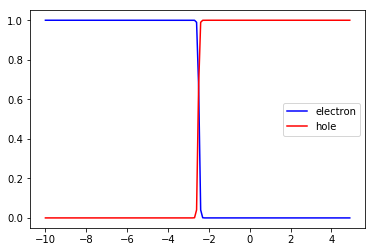

In [23]:
fH = 1/(1/2*np.exp(-(y-EF)/kT)+1)
fL = 1/(1/2*np.exp((y-EF)/kT)+1)
plt.plot(y, fL, 'b', label = 'electron')
plt.plot(y, fH, 'r', label = 'hole')
plt.legend()

# Define Geometry

In [24]:
geo = np.zeros(len(z))
geo1 = 50e-9 / dz
geo2 = geo1 + 50e-9 / dz 
geo3 = geo2 + 50e-9 / dz
geo1 = np.int(geo1) + 1
geo2 = np.int(geo2) + 1
geo3 = np.int(geo3) + 1
print geo1, geo2, geo3

250 500 750


# Density of States

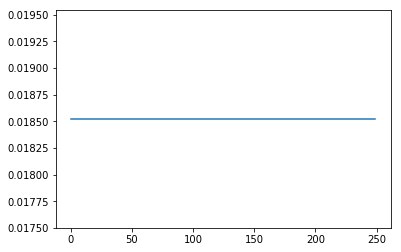

In [25]:
dosH = np.zeros((len(y), len(z)))
dosL = np.zeros((len(y), len(z)))
ne = np.zeros((len(y), len(z)))
nh = np.zeros((len(y), len(z)))

for i in range(len(geo)):
    dosH[:,i] = gaussian(y, EH, 0.25)   
    dosL[:,i] = gaussian(y, EL, 0.25)   
    ne[:,i] = dosL[:,i]*fL  # [/E /dz]
    nh[:,i] = dosH[:,i]*fH
neSum = np.sum(ne, axis = 0)*dE  # [/dz]
nhSum = np.sum(nh, axis = 0)*dE 
qden_old = q*n*(nhSum - neSum) # [C/m2/dz]  

plt.plot(neSum)

# Define Inhomogeneous Poisson Matrix

In [26]:
z_boundary = 0 #Dirichlet : 0    Neumann : 1

if z_boundary == 0:
    poisson = diags(-np.append(c_array[1:], c_array[-1]) - np.append(c_array[0], c_array[:-1])) \
          + diags(c_array[1:], 1) + diags(c_array[:-1], -1)
    #poisson[-1,-1] =  V*c_array[-1] / dz
    
elif z_boundary == 1:
    poisson = diags(-np.append(c_array[1:], c_array[-1]) - np.append(c_array[0], c_array[:-1])) \
          + diags(c_array[1:], 1) + diags(c_array[:-1], -1)
    poisson[-1,-2] *= 2
    #poisson[-1,-1] =  V*c_array[-1]/dz
    #poisson[-1,-1] = 2*c_array[-1] 
    #poisson[-1,-2] = -c_array[-1] *2
poisson /= (dz)
poisson = csr_matrix(poisson)
#p = poisson.todense()

# Initial guess

-32.7578120763 -34.7418758213


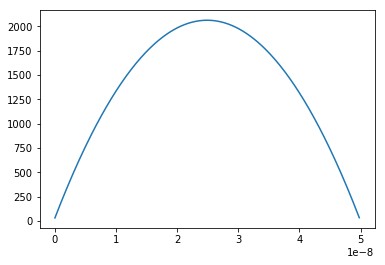

In [27]:
#qden_old /= 1000
#Vz = np.linalg.solve(poisson, -qden_old/eo)
if z_boundary == 0:
    qden_old[-1] -= (V*c_array[-1] / dz * eo)
Vz = spsolve(poisson, -qden_old/eo)
#fig, ax1 = plt.subplots(1,2)
plt.plot(z, -Vz)
#plt.ylim([-1.1,0])
print Vz[0], Vz[-1]

# Iteration

In [28]:
dosH = np.zeros((len(y), len(z)))
dosL = np.zeros((len(y), len(z)))
ne = np.zeros((len(y), len(z)))
nh = np.zeros((len(y), len(z)))

for k in range(50000):
    if z_boundary == 0:
        qden_boundary = qden_old + 0
        qden_boundary[-1] = qden_old[-1] - V*c_array[-1] / dz * eo
#        qden_old[-1] -= (V*c_array[-1] / dz * eo)
        Vz = spsolve(poisson, -qden_boundary/eo)
    else:
        Vz = spsolve(poisson, -qden_old/eo)
    
    for i in range(len(geo)):
        dosH[:,i] = gaussian(y, EH-Vz[i], 0.25)   
        dosL[:,i] = gaussian(y, EL-Vz[i], 0.25)   
        ne[:,i] = dosL[:,i]*fL  # [/E /dz]
        nh[:,i] = dosH[:,i]*fH
   
    neSum = np.sum(ne, axis = 0)*dE  # [/dz]
    nhSum = np.sum(nh, axis = 0)*dE 
    qden_new = q*n*(nhSum - neSum) # [C/m2/dz]    
   
    diff = np.sum(qden_old - qden_new)
    qden_old = (qden_old*999/1000 + qden_new/1000)
    if k % 1000 == 0:
        print k, diff
    #qden_new *= 1000
    #plt.plot(z, -Vz)
#    plt.plot(y, dosL, 'r',  label = 'DOS_E')
    #plt.plot(y, dosL, 'g', label = 'DOS_H')
    if np.abs(diff) < 1e-6:
        break

0 -10.7527002821
1000 -3.95371869766
2000 -3.2462362417
3000 106.774981258
4000 -33.3987818953
5000 48.5759671464
6000 39.228817466
7000 22.338253253
8000 77.482248147
9000 -167.59240336
10000 61.5358151863
11000 -62.5420836497
12000 47.0212105609
13000 6.8992031987
14000 -49.474467249
15000 235.585786158
16000 -175.782656819
17000 220.014559542
18000 161.764102913
19000 -42.1579559255
20000 149.308436203
21000 -3.04995977249
22000 47.0081258126
23000 40.7123883331
24000 -261.434879448
25000 -67.6943311073
26000 87.8497404273
27000 106.534015816
28000 -24.0162126497
29000 -252.114423514
30000 -8.59120809882
31000 -97.5119992562
32000 18.5934626001
33000 81.5432829605
34000 130.895495157
35000 -2.74036378979
36000 70.9934779556
37000 153.481241803
38000 -141.02855603
39000 40.8737086075
40000 -56.9305395936
41000 -113.942807731
42000 -91.0552354173
43000 -24.6931740246
44000 122.825992901
45000 -116.48104228
46000 -3.34625232512
47000 8.78306979214
48000 -51.259768986
49000 -9.094039154

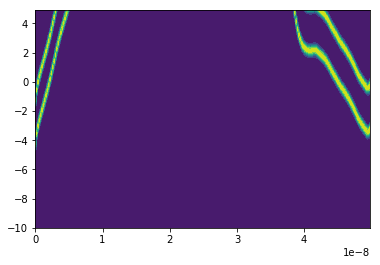

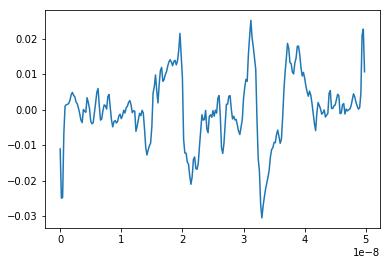

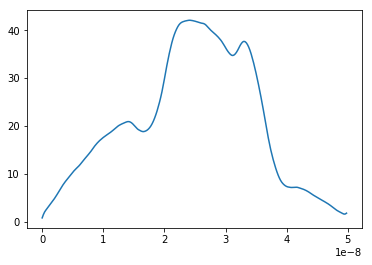

In [29]:
plt.contourf(z,y,dosL+dosH)
plt.figure()
plt.plot(z, qden_old)
plt.figure()
plt.plot(z, -Vz)